In [1]:
from google.colab import drive
from os import chdir, getcwd

drive.mount('/content/gdrive')
chdir("/content/gdrive/My Drive/SSD_ADAS/ssd_keras/")
print("Working directory:", getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Working directory: /content/gdrive/My Drive/SSD_ADAS/ssd_keras


In [2]:
from data_generator.object_detection_2d_data_generator import DataGenerator

input_format = ["image_name", "class_id", "xmin", "xmax", "ymin", "ymax"] # order of columns in the annotation csv

# Load validation data
validation_image_dir = "../FLIR_ADAS/validation/PreviewData"
validation_annotation_csv = "../validation.csv"

validation_dataset = DataGenerator()
validation_dataset.parse_csv(
    validation_image_dir,
    validation_annotation_csv,
    input_format
)
print("{} images in validation set.".format(validation_dataset.get_dataset_size()))

# Load training data
training_image_dir = "../FLIR_ADAS/training/PreviewData"
training_annotation_csv = "../training.csv"

training_dataset = DataGenerator()
training_dataset.parse_csv(
    training_image_dir,
    training_annotation_csv,
    input_format
)
print("{} images in training set.".format(training_dataset.get_dataset_size()))

1360 images in validation set.
7860 images in training set.


In [3]:
! ls *.h5

ssd300_alpha1_newaug_epoch-174_loss-3.7961_val_loss-3.3007.h5
ssd300_alpha1_newaug_epoch-175_loss-3.9203_val_loss-3.3743.h5
ssd300_alpha1_newaug_epoch-176_loss-3.9218_val_loss-3.3427.h5
ssd300_alpha1_newaug_epoch-179_loss-3.9354_val_loss-3.3120.h5
ssd300_alpha1_newaug_epoch-183_loss-3.8273_val_loss-3.3090.h5
ssd300_alpha1_newaug_epoch-184_loss-3.8187_val_loss-3.3009.h5
ssd300_alpha1_newaug_epoch-185_loss-3.8150_val_loss-3.2687.h5
ssd300_alpha1_newaug_epoch-188_loss-3.7672_val_loss-3.2388.h5
ssd300_alpha1_newaug_epoch-189_loss-3.8069_val_loss-3.2372.h5
ssd300_alpha1_newaug_epoch-194_loss-3.7543_val_loss-3.2210.h5
ssd300_alpha1_newaug_epoch-195_loss-3.7363_val_loss-3.2185.h5
ssd300_alpha1_newaug_epoch-196_loss-3.7262_val_loss-3.1950.h5
ssd300_alpha1_newaug_epoch-200_loss-3.7038_val_loss-3.1938.h5
ssd300_alpha1_newaug_epoch-201_loss-3.7243_val_loss-3.1838.h5
ssd300_alpha1_newaug_epoch-206_loss-3.6875_val_loss-3.1735.h5
ssd300_alpha4_epoch-121_loss-7.7476_val_loss-6.3080.h5
ssd300_alpha4_e

In [46]:
from keras import backend as K
from keras.models import load_model

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_loss_function.keras_ssd_loss import SSDLoss

def load_ssd(h5_filename):
  #Clear previously loaded models
  K.clear_session()
  
  #Fill in the custom objects so that Keras can load the model
  ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
  
  custom_objects = {
      'AnchorBoxes': AnchorBoxes,
      'L2Normalization': L2Normalization,
      'DecodeDetections': DecodeDetections,
      'compute_loss': ssd_loss.compute_loss}
  
  #Load the model
  model = load_model(h5_filename, custom_objects)
  print("Model loaded:", h5_filename)
  
  return model
  
model = load_ssd("ssd300_untrained_coco.h5")

Model loaded: ssd300_untrained_coco.h5


In [0]:
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder

img_height = 300
img_width = 300
n_classes = 80 # COCO classes

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                         [1.0, 2.0, 0.5],
                         [1.0, 2.0, 0.5]]

two_boxes_for_ar1=True
steps=[8, 16, 32, 64, 100, 300]
offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes=False
variances=[0.1, 0.1, 0.2, 0.2]
normalize_coords=True

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios_per_layer,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

In [0]:
from data_generator.object_detection_2d_geometric_ops import Resize, ResizeRandomInterp
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDExpand, SSDRandomCrop, SSDDataAugmentation
from data_generator.object_detection_2d_geometric_ops import RandomFlip
from data_generator.object_detection_2d_image_boxes_validation_utils import BoxFilter

import cv2

mean_color = [128, 128, 128]

##DEBUG
ssd_orig = SSDDataAugmentation()

# For validation images
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# SSD augmentation chain without photometric ops
expand = SSDExpand(background=mean_color)
random_crop = SSDRandomCrop()
random_flip = RandomFlip(dim='horizontal', prob=0.5)
box_filter = BoxFilter(check_overlap=False, check_min_area=False, check_degenerate=True)
resize_random_interp = ResizeRandomInterp(
    height=img_height,
    width=img_width,
    interpolation_modes=[cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4],
    box_filter=box_filter)

In [0]:
# Create training and validation generators
batch_size = 1

val_generator = validation_dataset.generate(
    batch_size=batch_size,
    shuffle=True,
    transformations= [convert_to_3_channels, resize],
    label_encoder=ssd_input_encoder,
    returns={'processed_images', 'encoded_labels'},
    keep_images_without_gt=False)

train_generator = training_dataset.generate(
    batch_size=batch_size,
    shuffle=True,
    transformations=[convert_to_3_channels, expand, random_crop, random_flip, resize_random_interp],
    label_encoder=ssd_input_encoder,
    returns={'processed_images', 'encoded_labels'},
    keep_images_without_gt=False)

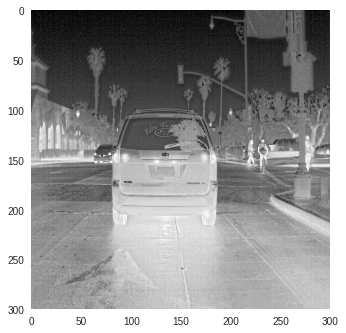

In [53]:
import matplotlib.pyplot as plt

img_batch = next(val_generator)[0]
img = img_batch[0,:,:,:]

plt.imshow(img)
plt.grid(False)

In [54]:
confidence_threshold = 0.2

import numpy as np
from ssd_encoder_decoder.ssd_output_decoder import decode_detections

raw_predictions = model.predict(img_batch)

y_pred = decode_detections(
  raw_predictions,
  confidence_thresh = confidence_threshold,
  input_coords = "centroids", #"corners",
  normalize_coords = False,
  img_height = img_height,
  img_width = img_width)

np.set_printoptions(precision=4, suppress=True, linewidth=90)
print(y_pred)

[array([[1.    , 0.8063, 0.7486, 0.4145, 0.7859, 0.5394],
       [1.    , 0.4572, 0.7114, 0.416 , 0.748 , 0.5208],
       [1.    , 0.2997, 0.1678, 0.0985, 0.2651, 0.3804],
       [3.    , 0.9497, 0.2156, 0.3029, 0.5968, 0.6867],
       [3.    , 0.5373, 0.2041, 0.4376, 0.2836, 0.501 ]])]


[1.     0.8063 0.7486 0.4145 0.7859 0.5394]
[1.     0.4572 0.7114 0.416  0.748  0.5208]
[1.     0.2997 0.1678 0.0985 0.2651 0.3804]
[3.     0.9497 0.2156 0.3029 0.5968 0.6867]
[3.     0.5373 0.2041 0.4376 0.2836 0.501 ]


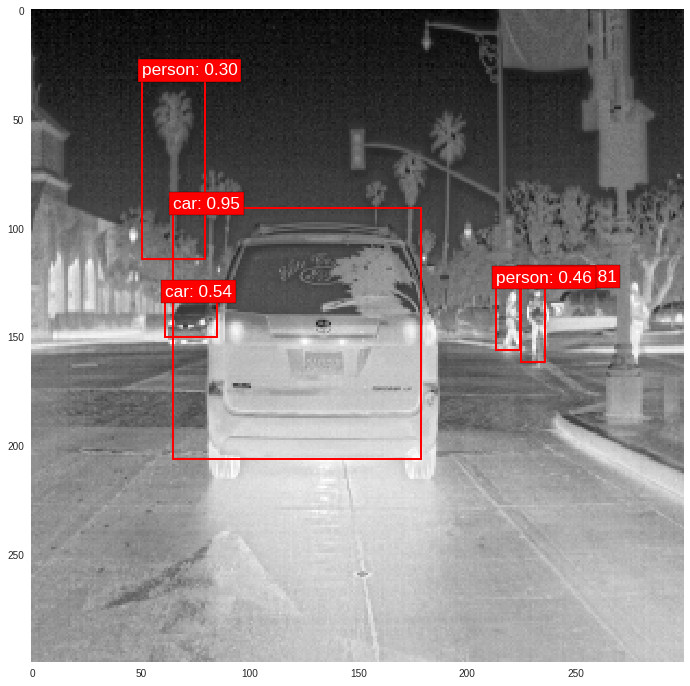

In [55]:
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.grid(False)
current_axis = plt.gca()

classes = {1:"person", 2:"bicycle", 3:"car", 17:"dog"}

for box in y_pred[0]:
    print(box)
    xmin = box[2] * 300
    ymin = box[3] * 300
    xmax = box[4] * 300
    ymax = box[5] * 300
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color="red", fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':"red", 'alpha':1.0})